<a href="https://colab.research.google.com/github/todnewman/coe_training/blob/master/Siamese_Network_Dog_vs_Cat_breeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout, MaxPooling2D, SpatialDropout2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate, Lambda
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from PIL import Image
import glob
import random
import cv2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import optimizers
import warnings
warnings.filterwarnings('ignore')

## Download zip file with dog and cat images from Tod's Google Drive.

This is faster than downloading the files due to Google Drive latency issues.

Also, download trained model to enable image segmentation prior to training our siamese network.

If there is a trained siamese network model on the Google Drive too, grab it also.

In [ ]:
%%time
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'/data/animals
%cp images.zip /content/images.zip
%cp /content/drive/'My Drive'/data/animals/*.h5 /content/.
%ls -l /content


Mounted at /content/drive
/content/drive/My Drive/data/animals
total 1832248
drwx------ 5 root root       4096 Jun 16 15:46 drive/
-rw------- 1 root root  788740006 Jun 16 15:46 images.zip
drwxr-xr-x 1 root root       4096 Jun  1 13:50 sample_data/
-rw------- 1 root root 1011651728 Jun 16 15:47 tod_similarity.h5
-rw------- 1 root root   75804992 Jun 16 15:47 tod_unet.h5
CPU times: user 963 ms, sys: 170 ms, total: 1.13 s
Wall time: 44.3 s


## Unzip the Images into the train folder

In [ ]:
%%time
%cd /content
!unzip images.zip

!rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/leonberger_92.jpg  
  inflating: images/British_Shorthair_120.jpg  
  inflating: images/staffordshire_bull_terrier_29.jpg  
  inflating: images/samoyed_139.jpg  
  inflating: images/english_setter_199.jpg  
  inflating: images/British_Shorthair_267.jpg  
  inflating: images/saint_bernard_48.jpg  
  inflating: images/yorkshire_terrier_45.jpg  
  inflating: images/samoyed_118.jpg  
  inflating: images/chihuahua_56.jpg  
  inflating: images/pug_50.jpg       
  inflating: images/Bombay_100.jpg   
  inflating: images/Maine_Coon_28.jpg  
  inflating: images/Siamese_82.jpg   
  inflating: images/British_Shorthair_268.jpg  
  inflating: images/basset_hound_110.jpg  
  inflating: images/Maine_Coon_241.jpg  
  inflating: images/saint_bernard_125.jpg  
  inflating: images/havanese_64.jpg  
  inflating: images/Maine_Coon_50.jpg  
  inflating: images/Bombay_61.jpg    
  inflating: images/saint_bernard_6.jpg  
  inflating: images

## GPU Info Blocks

Probably won't see a high memory session unless you have subscribed to CoLab Pro.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jun 16 15:47:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## Create a dictionary of labels based off what's in the train directory

We are removing everything after the first period in the file name and the resultant will be the image's label (should be "dog" or "cat")

In [ ]:
all_files = os.listdir('/content/images')
lab_arr = []
for f in all_files:
    label = f.rsplit('_', 1)[0]
    lab_arr.append(label)

myset = set(lab_arr)
lab_arr = list(myset)

label_dict = {label:index for index, label in enumerate(lab_arr)}
print(label_dict)

{'Abyssinian': 0, 'Siamese': 1, 'beagle': 2, 'keeshond': 3, 'leonberger': 4, 'english_cocker_spaniel': 5, 'Russian_Blue': 6, 'japanese_chin': 7, 'samoyed': 8, 'shiba_inu': 9, 'saint_bernard': 10, 'Bengal': 11, 'great_pyrenees': 12, 'Ragdoll': 13, 'american_pit_bull_terrier': 14, 'Bombay': 15, 'english_setter': 16, 'pomeranian': 17, 'havanese': 18, 'chihuahua': 19, 'Egyptian_Mau': 20, 'scottish_terrier': 21, 'yorkshire_terrier': 22, 'boxer': 23, 'Maine_Coon': 24, 'pug': 25, 'basset_hound': 26, 'miniature_pinscher': 27, 'wheaten_terrier': 28, 'german_shorthaired': 29, 'staffordshire_bull_terrier': 30, 'British_Shorthair': 31, 'Persian': 32, 'newfoundland': 33, 'Sphynx': 34, 'Birman': 35, 'american_bulldog': 36}


## Image Generator

This does a few things:
1.  It takes an array of arrays of image groupings (in this case, [[dog images],[cat images]] and builds two batches.  
2.  Each batch has 1/2 of its images matching the associated image in the other batch and the other 1/2 are not matches.  This allows us to train on images that match each other as well as on images that do not match.  The dataset should be balanced this way.
3.  Scaling and reshaping occur to each of the two batches separately.
4.  Each batch is inferenced against the trained segmentation model to segment the animal from the background.  This seems to work pretty well.
5.  the mask and the image are then combined and the background is darkened almost to black.

Generators are created at the end for both the training and the test images

In [ ]:
def equalize_hist(img):
    for c in range(0, 2):
       img[:,c] = cv2.equalizeHist(img[:,c])

    return img

def image_generator(in_groups, batch_size = 16, sz = (256, 256)):
    batch_halfsize = batch_size//2
    while True:
        files, labels, names = [], [], []
        batch_x, batch_y = [], []
        
        out_img_a, out_img_b, out_score = [], [], []
        all_groups = list(range(len(in_groups)))
        for match_group in [True, False]:
            group_idx = np.random.choice(all_groups, size = batch_halfsize)
            batch_x += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
            if match_group:
                b_group_idx = group_idx
                out_score += [1]*batch_halfsize
            else:
                # anything but the same group
                non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
                b_group_idx = non_group_idx
                out_score += [0]*batch_halfsize
                
            batch_y += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
        
        # Filenames to support generation of images
        batch_x = np.array(batch_x) # Filenames for Class X
        batch_y = np.array(batch_y) # Filenames for Class Y

        raw_x, raw_y = [],[]
        
        # Go through filenames and grab the associated image and process it.

        for f in batch_x: 
            #preprocess the raw images 
            raw = Image.open(f'/content/images/{f}')
            #Resize and Scale Images using Sklearn's scalers
            raw = cv2.resize(np.float32(raw), (224, 224), interpolation=cv2.INTER_AREA)
            
            #check the number of channels because some of the images are RGBA or GRAY
            if len(raw.shape) == 2:              
                raw = np.stack((raw,)*3, axis=-1)
            else:
                raw = raw[:,:,0:3]
            
            # Get the segmented image from the pre-trained segmenter
            #msk = get_mask(raw)
            #raw = raw*msk
            #raw = equalize_hist(raw)
            #raw = gabor(raw)
            #raw = cv2.GaussianBlur(raw, (5, 5), 0)
            raw_x.append(raw)


        for f in batch_y:
            #preprocess the raw images 
            raw = Image.open(f'/content/images/{f}')
            raw = cv2.resize(np.float32(raw), (224, 224), interpolation=cv2.INTER_AREA)

            #check the number of channels because some of the images are RGBA or GRAY
            if len(raw.shape) == 2:             
                raw = np.stack((raw,)*3, axis=-1)
            else:
                raw = raw[:,:,0:3]

            # Get the segmented image from the pre-trained segmenter
            #msk = get_mask(raw)
            #raw = raw*msk
            #raw = equalize_hist(raw)
            #raw = gabor(raw)
            #raw = cv2.GaussianBlur(raw, (5, 5), 0)
            raw_y.append(raw)


        batch_x = preprocess_input(np.array(raw_x))
        batch_y = preprocess_input(np.array(raw_y))

        yield np.stack(batch_x), np.stack(batch_y), np.stack(out_score)

import keras
from random import shuffle

file_loc = '/content/images'
#all_files = os.listdir('images')
all_files = os.listdir(file_loc)
shuffle(all_files)

split = int(0.7 * len(all_files))

#split into training and testing
x_train = np.array(all_files[0:split])
x_test  = np.array(all_files[split:])

#x_train = np.random.choice(x_train, size = 200)
#x_test = np.random.choice(x_train, size = 80)

y_train = []
for f in x_train:
    label = f.rsplit('_', 1)[0]
    y_train.append(label_dict[label])

y_test = []
for f in x_test:
    label = f.rsplit('_', 1)[0]
    y_test.append(label_dict[label])

y_train = np.array(y_train)
y_test = np.array(y_test)

# reorganize by groups
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train_generator = image_generator(train_groups, batch_size = 16)
test_generator  = image_generator(test_groups, batch_size = 16)

def gen_random_batch(gen, batch_size):
    x, y, score = next(gen, batch_size)
    return x,y,score

train groups: [145, 137, 127, 138, 145, 136, 146, 137, 143, 151, 144, 144, 137, 145, 135, 136, 149, 147, 129, 137, 147, 145, 147, 142, 132, 135, 138, 136, 141, 146, 132, 139, 137, 153, 134, 124, 137]
test groups: [55, 63, 73, 62, 55, 64, 54, 63, 57, 49, 56, 56, 63, 55, 65, 64, 51, 53, 71, 63, 53, 54, 53, 58, 68, 65, 62, 64, 59, 54, 59, 61, 63, 47, 66, 76, 63]


## Misc Functions

* mean_iou(): Here only because it's a custom loss function and is needed to load the segmentation model using load_model
* get_mask(): Function we've created to predict the mask for our raw dog and cat images
* t_swish(): Custom activation function that seems to work at least as well as relu.
* gabor(): Experimental function.  Goal is to build a function that can apply gabor filter to the first layer of the NN.  In Work. 

In [ ]:
saved_seg_model = '/content/tod_unet.h5'

def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

model_tr = load_model(saved_seg_model, custom_objects={'mean_iou':mean_iou})

def get_mask(raw):
    # Predict the mask.  Believe that in this approach predict_on_batch might be
    #   faster than 'predict'
    pred = model_tr.predict_on_batch(np.expand_dims(raw, 0))
    #pred = model_tr(np.expand_dims(raw, 0))  # This might be faster...

    #mask post-processing 
    msk = tf.squeeze(pred)
    msk = np.stack((msk,)*3, axis=-1)
    msk[msk >= 0.5] = 1 
    msk[msk < 0.5] = 0.1 # make this zero if you want solid black background
    return msk

def t_swish(x):
    return (K.sigmoid(x) * x * 1.5 -1)

import numpy as np
import cv2
from google.colab.patches import cv2_imshow

sz = (256, 256)

def gabor(image) :
   """
   Using Gabor Filters to repair
   motion blurriness in an image.
   """
   theta = [0, 45, 90, 135]
   filtered_images = []
   sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
   for th in theta :
      kernel = cv2.getGaborKernel(ksize = (3, 3), sigma = 5, lambd = 5, theta = th, 
               gamma = 0.25)
      kernel = tf.expand_dims(kernel, 0)
      kernel = tf.expand_dims(kernel, 0)
      kernel = tf.cast(kernel, tf.float32)
      filtered_images.append(tf.nn.conv2d(image, kernel, strides=[1, 1, 1, 1], 
                             padding='SAME'))
   final_img = tf.math.maximum(tf.math.maximum(filtered_images[0], 
   filtered_images[1]), tf.math.maximum(filtered_images[2], filtered_images[3]))

   #Sharpening the image
   sharpen_kernel = tf.expand_dims(sharpen_kernel, 0)
   sharpen_kernel = tf.expand_dims(sharpen_kernel, 0)
   sharpen_kernel = tf.cast(sharpen_kernel, tf.float32)
   return tf.nn.conv2d(final_img, sharpen_kernel, strides=[1, 1, 1, 1], 
                       padding='SAME')

## Use a Pretrained ResNet50 as the Feature model

In [ ]:
# Two inputs one each - left and right image
leaky = LeakyReLU(alpha=0.05)
left_input = Input((224,224,3))
right_input = Input((224,224,3))

convnet = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
# Add the final fully connected layers

x = convnet.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
#x = Dense(1024, activation= 'relu')(x)
preds = Dense(18, activation='sigmoid')(x) # Apply sigmoid

convnet = Model(inputs=convnet.input, outputs=preds)#Applying above model for both the left and right images

encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# Concatenate results into a similarity model
combined_features = concatenate([encoded_l, encoded_r], name = 'merge_features')
combined_features = Dense(500, activation = 'relu')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Dropout(0.4)(combined_features)
prediction = Dense(1, activation = 'sigmoid')(combined_features)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction, name = 'Siamese_Network')#define the optimizer. Here I have used SGD with nesterov momentum
optim = optimizers.SGD(lr=0.005, decay=.01, momentum=0.9, nesterov=True) #compile the network using binary cross entropy loss and the above optimizer
#optim = optimizers.Nadam(lr = 0.001)
siamese_net.compile(loss="binary_crossentropy",optimizer=optim,metrics=['mean_absolute_error','accuracy'])
siamese_net.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 18)           23624594    ['input_1[0][0]',                
                   

In [ ]:
# Compile our similarity model to setup the optimization process
from keras.models import Model, load_model
%cd /content/drive/'My Drive'/data/

def contrastive_loss(y_true, y_pred):
    
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    y_true = float(y_true)


    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + float(1 - y_true) * margin_square)

def build_callbacks():
        modelCP = ModelCheckpoint(filepath='siamese_model_breeds.h5', 
                                  monitor='val_mean_absolute_error', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  period=1)
        LR = ReduceLROnPlateau(monitor='val_mean_absolute_error', 
                        patience=10, 
                        verbose=1, 
                        factor=0.2, 
                        min_lr=0.00001)
        callbacks = [modelCP,  LR]
        return callbacks

    
#%cd /content/drive/'My Drive'/data/dogs_and_cats

retrain = False

if retrain:
    siamese_net = load_model('siamese_model_breeds.h5', custom_objects={'contrastive_loss': contrastive_loss, 't_swish':t_swish, 'LeakyReLU': LeakyReLU})    

/content/drive/My Drive/data


In [ ]:

def show_model_output(generator, nb_examples = 8):
    pv_a, pv_b, score = gen_random_batch(generator, nb_examples)

    pred_sim = siamese_net([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (30,12))
    for c_a, c_b, p_d, a_d, (ax1, ax2) in zip(pv_a, pv_b, pred_sim, score, m_axs.T):
        img1 = c_a/np.amax(c_a)
        img1 = np.clip(img1, 0, 1)
        ax1.imshow(img1)
        ax1.set_title('Image A\n Act: %3.0f%%' % (100*a_d))
        ax1.axis('off')
        img2 = c_b/np.amax(c_b)
        img2 = np.clip(img2, 0, 1)
        ax2.imshow(img2)
        ax2.set_title('Image B\n Pred: %3.0f%%' % (100*p_d))
        ax2.axis('off')

    return fig



Epoch 1/13
200/200 [==============================] - 67s 236ms/step - loss: 0.7176 - mean_absolute_error: 0.4723 - accuracy: 0.5512 - val_loss: 0.6647 - val_mean_absolute_error: 0.4847 - val_accuracy: 0.6875 - lr: 0.0050
Epoch 2/13
200/200 [==============================] - 46s 229ms/step - loss: 0.5844 - mean_absolute_error: 0.3997 - accuracy: 0.6825 - val_loss: 0.5963 - val_mean_absolute_error: 0.4340 - val_accuracy: 0.6875 - lr: 0.0050
Epoch 3/13
200/200 [==============================] - 45s 227ms/step - loss: 0.5562 - mean_absolute_error: 0.3777 - accuracy: 0.7100 - val_loss: 0.5196 - val_mean_absolute_error: 0.3692 - val_accuracy: 0.6875 - lr: 0.0050
Epoch 4/13
200/200 [==============================] - 45s 225ms/step - loss: 0.5224 - mean_absolute_error: 0.3542 - accuracy: 0.7391 - val_loss: 0.4681 - val_mean_absolute_error: 0.3270 - val_accuracy: 0.8125 - lr: 0.0050
Epoch 5/13
200/200 [==============================] - 45s 225ms/step - loss: 0.4750 - mean_absolute_error: 0.323

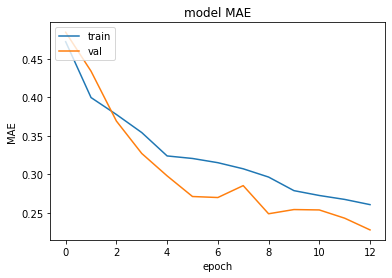

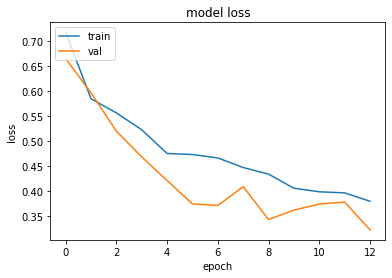

In [ ]:
# make a generator out of the data.  Yield images A and B and score.
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
train_batch = 16



def siam_gen(gen, batch_size = train_batch):
    while True:
        pv_a, pv_b, score = gen_random_batch(gen, batch_size)
        yield [pv_a, pv_b], score

steps_per_epoch = 200      
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_generator, 16)

# Fit the model using Keras' fit_generator.

loss_history = siamese_net.fit(siam_gen(train_generator), 
                               steps_per_epoch = steps_per_epoch,
                               validation_data=([valid_a, valid_b], valid_sim),
                               epochs = 13, 
                               callbacks = build_callbacks(),
                               verbose = True)

from matplotlib import pyplot as plt
plt.plot(loss_history.history['mean_absolute_error'])
plt.plot(loss_history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(loss_history.history['loss'])
plt.plot(loss_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

/content/drive/My Drive/data


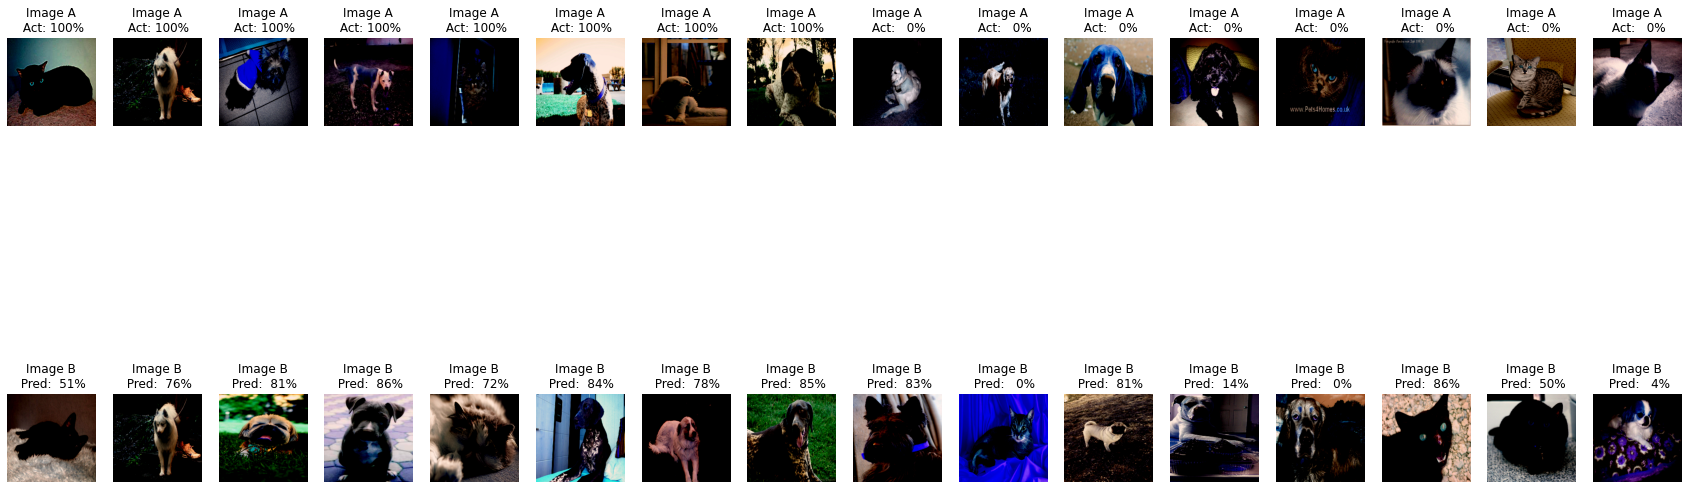

In [ ]:
%cd /content/drive/'My Drive'/data/
saved_model = 'siamese_model_breeds.h5'


siamese_net = load_model(saved_model, custom_objects={'contrastive_loss': contrastive_loss, 't_swish': t_swish, 'LeakyReLU': LeakyReLU}) 

_ = show_model_output(test_generator, 16)


In [ ]:
tv_a, tv_b, score = gen_random_batch(test_generator, 16)

def show_model_val_scores(siamese_net, integ_left, integ_right, integ_target, nb_examples = 16):
    newSize = (256,256)
    pred_sim = siamese_net.predict_on_batch([integ_left, integ_right])
    pred_sim = [val for sublist in pred_sim for val in sublist] 
    passes = 0
    fails = 0
    for act, pred in zip(integ_target, pred_sim):
        if abs(act-pred) < 0.45: 
            score = 'pass'
            passes+=1
        else: 
            score = 'fail'
            fails+=1

        print(f'Integration Set: Actual: {act}  Predicted: {pred:2.2}   Score: {score}')
    print('**********************************************************************************')
    print(f'OVERALL RESULTS: Passes: {passes}  Fails: {fails}')

_ = show_model_val_scores(siamese_net, tv_a, tv_b, score,8)

Integration Set: Actual: 1  Predicted: 0.71   Score: pass
Integration Set: Actual: 1  Predicted: 0.87   Score: pass
Integration Set: Actual: 1  Predicted: 0.79   Score: pass
Integration Set: Actual: 1  Predicted: 0.88   Score: pass
Integration Set: Actual: 1  Predicted: 0.86   Score: pass
Integration Set: Actual: 1  Predicted: 0.81   Score: pass
Integration Set: Actual: 1  Predicted: 0.6   Score: pass
Integration Set: Actual: 1  Predicted: 0.77   Score: pass
Integration Set: Actual: 0  Predicted: 0.016   Score: pass
Integration Set: Actual: 0  Predicted: 0.0019   Score: pass
Integration Set: Actual: 0  Predicted: 0.043   Score: pass
Integration Set: Actual: 0  Predicted: 0.0005   Score: pass
Integration Set: Actual: 0  Predicted: 0.0057   Score: pass
Integration Set: Actual: 0  Predicted: 0.15   Score: pass
Integration Set: Actual: 0  Predicted: 0.18   Score: pass
Integration Set: Actual: 0  Predicted: 0.48   Score: fail
*****************************************************************

## Backup Modules

In [ ]:
model = Sequential()

depth = 4
width = 16
activation = t_swish
dropout = 0.4

x_train, y_train, score = gen_random_batch(train_generator, 8)

# Define Input Layer Up front.
input_shape = x_train.shape[1:]

model.add(Conv2D(filters = width, kernel_size = (7,7), padding = 'Same', 
                        activation = activation, 
                        input_shape = input_shape
                     ))

for layer in range(depth):

    model.add(Conv2D(filters = width, kernel_size = (3,3),padding = 'Same', 
                        activation = activation                        
                     ))
    model.add(BatchNormalization())
    
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dropout/2))

for layer in range(depth):

    model.add(Conv2D(filters = width*2, kernel_size = (3,3),padding = 'Same', 
                    activation = activation))
    model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(dropout))

for layer in range(depth):

    model.add(Conv2D(filters = width*2, kernel_size = (3,3),padding = 'Same', 
                    activation = activation))
    model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(dropout))

for layer in range(depth):

    model.add(Conv2D(filters = width*2, kernel_size = (3,3),padding = 'Same', 
                    activation = activation, activity_regularizer=regularizers.l2(1e-6)))
    model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(dropout))

model.add(Flatten())
model.add(Dense(16))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(dropout))



In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout

#x_train, y, nm = next(train_generator)
x_train, y_train, score = gen_random_batch(train_generator, 8)

# Define Input Layer Up front.
img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
n_layer = img_in

# Create our convolutional network in a compressing fashion... 
# 4 Conv Layers with 8, 16, 16, and 32 filters respectively.
leaky = LeakyReLU(alpha=0.05)
activation = leaky

# Define Input Layer Up front.
img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
n_layer = img_in

# Create our convolutional network in a compressing fashion... 
# 4 Conv Layers with 8, 16, 16, and 32 filters respectively.


n_layer = Conv2D(128, kernel_size = (5,5))(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation(activation)(n_layer)
n_layer = Conv2D(64, kernel_size = (3,3))(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation(activation)(n_layer)
n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Conv2D(32, kernel_size = (3,3))(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation(activation)(n_layer)
n_layer = Conv2D(16, kernel_size = (3,3))(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation(activation)(n_layer)
n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32)(n_layer)
n_layer = Activation('linear')(n_layer)


feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 252, 252, 128)     9728      
_________________________________________________________________
batch_normalization_11 (Batc (None, 252, 252, 128)     512       
_________________________________________________________________
activation (Activation)      (None, 252, 252, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 64)      73792     
_________________________________________________________________
batch_normalization_12 (Batc (None, 250, 250, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 250, 250

In [ ]:
from keras.layers import concatenate, Lambda

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


# Our Similarity Model will Have Dual Inputs, one for each image
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')

# Run each Input layer through the feature model
#img_a_feat = feature_model(img_a_in)
#img_b_feat = feature_model(img_b_in)
img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

# Getting the L1 Distance between the 2 encodings
L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))
#distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([img_a_feat, img_b_feat]])
distance = Lambda(lambda tensor:K.sqrt(K.sum(K.square(tensor[0] - tensor[1]), axis=1, keepdims=True)) )

# Add the distance function to the network
L1_distance = L1_layer([img_a_feat, img_b_feat])
Euclidean_distance = distance([img_a_feat, img_b_feat])

#prediction = Dense(1,activation='sigmoid')(L1_distance)
prediction = Dense(1,activation='sigmoid')(Euclidean_distance)
similarity_model = Model(inputs=[img_a_in, img_b_in],outputs=prediction)
similarity_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageA_Input (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
ImageB_Input (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
FeatureGenerationModel (Functio (None, 32)           24120480    ImageA_Input[0][0]               
                                                                 ImageB_Input[0][0]               
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           FeatureGenerationModel

In [ ]:
#
#  Densenet Class
#  Usage:  densenet = DenseNet((28,28,1), nb_classes=10, dropout_rate=0.3, depth=8)
#
leaky = LeakyReLU(alpha=0.05)

class DenseNet:
    def __init__(self, input_shape=None, dense_blocks=3, dense_layers=-1, growth_rate=6, nb_classes=None,
                 dropout_rate=None, bottleneck=False, compression=1.0, weight_decay=1e-4, depth=20):

        # Checks
        if nb_classes == None:
            raise Exception( 'Please define number of classes (e.g. num_classes=10). This is required for final softmax.')

        if compression <= 0.0 or compression > 1.0:
            raise Exception('Compression have to be a value between 0.0 and 1.0.')

        if type(dense_layers) is list:
            if len(dense_layers) != dense_blocks:
                raise AssertionError('Number of dense blocks have to be same length to specified layers')
        elif dense_layers == -1:
            dense_layers = int((depth - 4) / 3)
            if bottleneck:
                dense_layers = int(dense_layers / 2)
            dense_layers = [dense_layers for _ in range(dense_blocks)]
        else:
            dense_layers = [dense_layers for _ in range(dense_blocks)]

        self.dense_blocks = dense_blocks
        self.dense_layers = dense_layers
        self.input_shape = input_shape
        self.growth_rate = growth_rate
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.bottleneck = bottleneck
        self.compression = compression
        self.nb_classes = nb_classes
        
        
    def build_model(self):
        img_input = Input(shape=self.input_shape, name='img_input')
        nb_channels = self.growth_rate
        
        x = Conv2D(2*self.growth_rate, (3,3), 
                   padding='same', strides = (1,1), 
                   kernel_regularizer=keras.regularizers.l2(self.weight_decay))(img_input)
        
        for block in range(self.dense_blocks-1):
            x, nb_channels = self.dense_block(x, self.dense_layers[block], nb_channels, self.growth_rate,
                                              self.dropout_rate, self.bottleneck, self.weight_decay)
            
            x = self.transition_layer(x, nb_channels, self.dropout_rate, self.compression, self.weight_decay)
            nb_channels = int(nb_channels*self.compression)
            
        x, nb_channels = self.dense_block(x, self.dense_layers[-1], nb_channels, self.growth_rate, self.dropout_rate, self.weight_decay)
        
        x = BatchNormalization()(x)
        x = Activation(leaky)(x)
        x = GlobalAveragePooling2D()(x)
        #prediction = Dense(self.nb_classes, activation='softmax')(x)
        prediction = Dense(16, activation='sigmoid')(x)
        return Model(inputs=img_input, outputs=prediction, name='densenet')
        
    def dense_block(self, x, nb_layers, nb_channels, growth_rate, dropout_rate=None, bottleneck=False, weight_decay=1e-4):
        for i in range(nb_layers):
            cb = self.convolution_block(x, growth_rate, dropout_rate, bottleneck)
            nb_channels += growth_rate
            x = concatenate([cb,x])
            
        return x, nb_channels
    
    def convolution_block(self, x, nb_channels, dropout_rate=None, bottleneck=False, weight_decay=1e-4):       

        # Bottleneck
        if bottleneck:
            bottleneckWidth = 4
            x = BatchNormalization()(x)
            x = Activation(leaky)(x)
            x = Conv2D(nb_channels * bottleneckWidth, (1, 1),
                                     kernel_regularizer=keras.regularizers.l2(weight_decay))(x)
            # Dropout
            if dropout_rate:
                x = Dropout(dropout_rate)(x)

        # Standard (BN-ReLU-Conv)
        x = BatchNormalization()(x)
        x = Activation(leaky)(x)
        x = Conv2D(nb_channels, (3, 3), padding='same')(x)

        # Dropout
        if dropout_rate:
            x = Dropout(dropout_rate)(x)

        return x

    def transition_layer(self, x, nb_channels, dropout_rate=None, compression=1.0, weight_decay=1e-4):
        x = BatchNormalization()(x)
        x = Activation(leaky)(x)
        x = Conv2D(int(nb_channels * compression), (1, 1), padding='same',
                                 kernel_regularizer=keras.regularizers.l2(weight_decay))(x)

        # Adding dropout
        if dropout_rate:
            x = Dropout(dropout_rate)(x)
        x = SpatialDropout2D(0.4, data_format=None)(x)
        x = AveragePooling2D((2, 2), strides=(2, 2))(x)
        return x
    
densenet = DenseNet((256,256,3), nb_classes=2, growth_rate = 20, dropout_rate=0.05, depth=10, 
                     weight_decay=1e-3)

model = densenet.build_model()

In [ ]:
from keras.layers import concatenate, Lambda

x_train, y_train, score = gen_random_batch(train_generator, 32 )

# Our Similarity Model will Have Dual Inputs, one for each image
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')

# Run each Input layer through the feature model
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
#img_a_feat = model(img_a_in)
#img_b_feat = model(img_b_in)

# Concatenate results into a similarity model
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = Dense(3000, activation = leaky)(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Dense(3000, activation = leaky)(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Dense(500, activation = leaky)(combined_features)
combined_features = BatchNormalization()(combined_features)
ombined_features = Dense(500, activation = leaky)(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Dropout(0.4)(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageA_Input (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
ImageB_Input (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
FeatureGenerationModel (Functio (None, 32)           1950800     ImageA_Input[0][0]               
                                                                 ImageB_Input[0][0]               
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 64)           0           FeatureGenerationM